# Fitting covid data for Pisa area #

## Data description
* __Data content__: number of positives to covid from ASL toscana website https://www.uslnordovest.toscana.it/notizie 
* __Data extension__: 2020-09-01 to now
* __Data frequency__: cpunts over past 24 hours
* __Data unit of measurement__: counts

In [1]:
# loading packages
#  %matplotlib notebook 
%matplotlib inline
import os
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
def exp_fitting_func(x, a, b, c):
    return a * np.exp(-b * x) + c

In [3]:
## Data acquisition

In [4]:
# accessing data from file
infile = os.path.normpath(r"./Data/input/Pisa_area.xlsx")

In [5]:
df_raw = pd.read_excel('{0}'.format(infile), 
                     delimiter=';',index_col=0, parse_dates=True, infer_datetime_format=True ) #, nrows=60)
df_raw.head(3)

,Pisa,Pisa (projected),Cascina,Cascina (projected),Pontedera,Pontedera (projected),Pisa (provincia),Pisa (provincia) projected),Toscana
Day,,,,,,,,,
2020-09-01,0.0,NaN,2.0,NaN,0.0,NaN,3,NaN,40
2020-09-02,2.0,NaN,0.0,NaN,0.0,NaN,3,NaN,69
2020-09-03,3.0,NaN,0.0,NaN,3.0,NaN,11,NaN,113


In [6]:
#df_raw.info()
#df_raw.describe()

In [7]:
#cleaning_not_useful columns
df_skim=df_raw.drop(['Pisa (projected)', 'Pontedera (projected)', 'Cascina (projected)', 'Pisa (provincia) projected)'], axis=1) 

## Basic visual exploration##
To confirm the content of the file, we take a look at the data time-trends. <br>


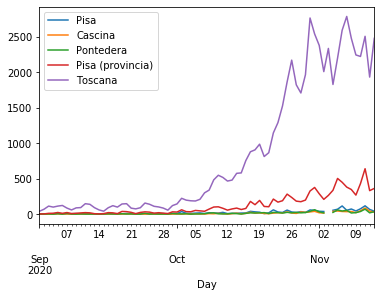

In [8]:
df_skim.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5787FB188>,
      dtype=object)

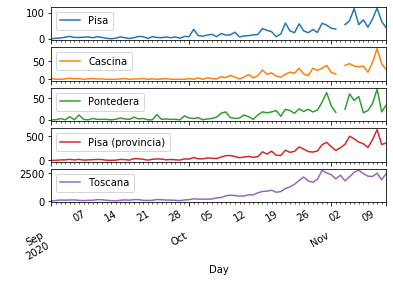

In [9]:
df_skim.plot(subplots=True)

## Preprocessing

1. fill nan interpolating () sometimes asl does not gives daily values


2. applying moving average because of during weekends there are less analysis done
first test: using exponential moving average
second test using simple average over n days

In [10]:
df_skim.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

In [11]:
df_skim['Pisa_provincia_EMA'] = df_skim['Pisa (provincia)'].ewm(span=3,adjust=False).mean()
df_skim.head()

,Pisa,Cascina,Pontedera,Pisa (provincia),Toscana,Pisa_provincia_EMA
Day,,,,,,
2020-09-01,0.0,2.0,0.0,3,40,3.00
2020-09-02,2.0,0.0,0.0,3,69,3.00
2020-09-03,3.0,0.0,3.0,11,113,7.00
2020-09-04,6.0,1.0,0.0,12,99,9.50
2020-09-05,9.0,3.0,7.0,23,113,16.25


In [12]:
df_skim['pandas_SMA_3'] = df_skim['Pisa (provincia)'].rolling(window=3).mean()
df_skim.tail()

,Pisa,Cascina,Pontedera,Pisa (provincia),Toscana,Pisa_provincia_EMA,pandas_SMA_3
Day,,,,,,,
2020-11-09,44.0,20.0,21.0,268,2244,321.463229,332.000000
2020-11-10,75.0,47.0,37.0,431,2223,376.231614,348.666667
2020-11-11,117.0,86.0,70.0,640,2507,508.115807,446.333333
2020-11-12,66.0,43.0,18.0,331,1932,419.557904,467.333333
2020-11-13,41.0,27.0,34.0,362,2478,390.778952,444.333333


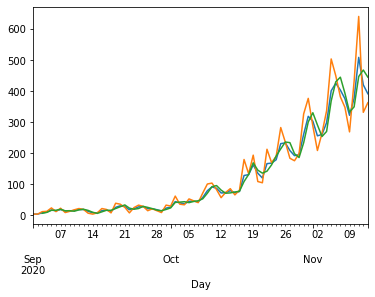

In [13]:
ax_1 = df_skim['Pisa_provincia_EMA'].plot()
ax_2 = df_skim['Pisa (provincia)'].plot()
ax_3 = df_skim['pandas_SMA_3'].plot()


In [14]:
df_Pisa_prov = df_skim['Pisa (provincia)'].dropna()
y = df_Pisa_prov.values
Pisa_pro_index = df_Pisa_prov.index

x = np.arange(len(y))

popt, pcov = scipy.optimize.curve_fit(exp_fitting_func, x, y, bounds=( [-100,-100,-100] , [100,100,100]   ))


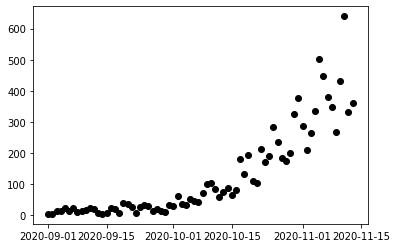

In [15]:
plt.plot(Pisa_pro_index, y, 'ko', label="Data. Today n(+) = {}" .format(int(y[-1])) )


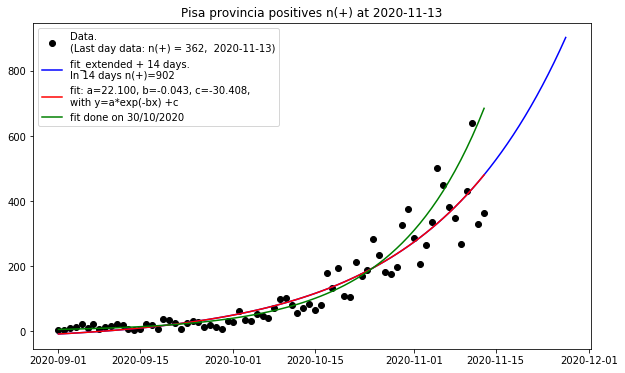

In [16]:
plt.figure(figsize=(10,6))


plt.title("Pisa provincia positives n(+) at {}".format(df_skim['Pisa (provincia)'].index[-1].date()) )
plt.plot(Pisa_pro_index, y, 'ko', label="Data. \n(Last day data: n(+) = {},  {})" .format(int(y[-1]), df_skim['Pisa (provincia)'].index[-1].date()) )



#plt.plot(x, y, 'ko', label="Data. Today n(+) = {}" .format(int(y[-1])) )
x_extended = np.arange(len(y)+14)
x_datetime_ext = dti = pd.date_range(Pisa_pro_index[0], periods=len(x_extended), freq='D')
#plt.plot(x_extended, exp_fitting_func(x_extended, *popt), 'b-', label="fit_extended + 14 days. \nIn 14 days from today, n(+)=%1i" %exp_fitting_func(x_extended[-1], *popt))
#plt.plot(x, exp_fitting_func(x, *popt), 'r-', label="fit: a=%5.3f, b=%5.3f, c=%5.3f, \nwith y=a*exp(-bx) +c" % tuple(popt))


plt.plot(x_datetime_ext, exp_fitting_func(x_extended, *popt), 'b-', label="fit_extended + 14 days. \nIn 14 days n(+)=%1i" %exp_fitting_func(x_extended[-1], *popt))
plt.plot(Pisa_pro_index, exp_fitting_func(x, *popt), 'r-', label="fit: a=%5.3f, b=%5.3f, c=%5.3f, \nwith y=a*exp(-bx) +c" % tuple(popt))


plt.plot(Pisa_pro_index, exp_fitting_func(x, 5.535, -0.066, 0.176), 'g-', label="fit done on 30/10/2020")



plt.legend()
plt.show()


In [17]:
df_skim['Pisa_SMA_3'] = df_skim['Pisa'].rolling(window=3).mean()
df_skim.tail()

,Pisa,Cascina,Pontedera,Pisa (provincia),Toscana,Pisa_provincia_EMA,pandas_SMA_3,Pisa_SMA_3
Day,,,,,,,,
2020-11-09,44.0,20.0,21.0,268,2244,321.463229,332.000000,56.666667
2020-11-10,75.0,47.0,37.0,431,2223,376.231614,348.666667,63.666667
2020-11-11,117.0,86.0,70.0,640,2507,508.115807,446.333333,78.666667
2020-11-12,66.0,43.0,18.0,331,1932,419.557904,467.333333,86.000000
2020-11-13,41.0,27.0,34.0,362,2478,390.778952,444.333333,74.666667


In [18]:
y = df_skim['Pisa'].dropna().values
x = np.arange(len(y))

popt, pcov = scipy.optimize.curve_fit(exp_fitting_func, x, y, bounds=( [-100,-100,-100] , [100,100,100]   ))

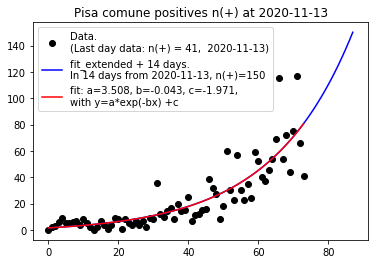

In [19]:
plt.figure()

plt.title("Pisa comune positives n(+) at {}".format(df_skim['Pisa'].index[-1].date()) )
#plt.plot(x, y, 'ko', label="Data. Today n(+) = {}" .format(int(y[-1])) )
plt.plot(x, y, 'ko', label="Data. \n(Last day data: n(+) = {},  {})" .format(int(y[-1]), df_skim['Pisa'].index[-1].date()) )


x_extended = np.arange(len(y)+14)
plt.plot(x_extended, exp_fitting_func(x_extended, *popt), 'b-', label="fit_extended + 14 days. \nIn 14 days from {}, n(+)={}".format(df_skim['Pisa'].index[-1].date(), int(exp_fitting_func(x_extended[-1], *popt))))
plt.plot(x, exp_fitting_func(x, *popt), 'r-', label="fit: a=%5.3f, b=%5.3f, c=%5.3f, \nwith y=a*exp(-bx) +c" % tuple(popt))

plt.legend()
plt.show()

In [20]:
y = df_skim['Toscana'].dropna().values
x = np.arange(len(y))

popt, pcov = scipy.optimize.curve_fit(exp_fitting_func, x, y, bounds=( [-100,-100,-100] , [100,100,100]   ))

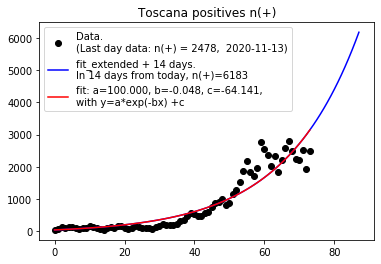

In [21]:
plt.figure()

plt.title("Toscana positives n(+)")
plt.plot(x, y, 'ko', label="Data. \n(Last day data: n(+) = {},  {})" .format(int(y[-1]), df_skim.index[-1].date()) )
x_extended = np.arange(len(y)+14)
plt.plot(x_extended, exp_fitting_func(x_extended, *popt), 'b-', label="fit_extended + 14 days. \nIn 14 days from today, n(+)=%1i" %exp_fitting_func(x_extended[-1], *popt))
plt.plot(x, exp_fitting_func(x, *popt), 'r-', label="fit: a=%5.3f, b=%5.3f, c=%5.3f, \nwith y=a*exp(-bx) +c" % tuple(popt))

plt.legend()
plt.show()

In [22]:
#basic exmaple of fitting

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.linspace(0,4,50)
y = func(x, 2.5, 1.3, 0.5)
yn = y + 0.2*np.random.normal(size=len(x))

In [23]:
popt, pcov = scipy.optimize.curve_fit(func, x, yn)

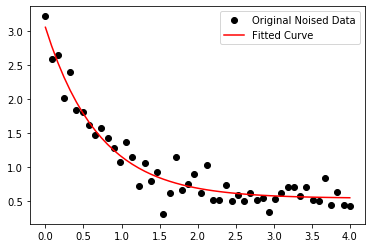

In [24]:
plt.figure()
plt.plot(x, yn, 'ko', label="Original Noised Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()